In [1]:
import sys
#sys.path.append('..')
from QAOA import QAOArunner
from MaxCutProblem import MaxCutProblem
import params
from rustworkx.visualization import mpl_draw as draw_graph
from old_jupyter_vizualisers.load_data import load_graph_from_csv

In [ ]:
import itertools

settings = {
'backend_mode' : ['statevector'],
'qaoa_variant': ['vanilla', 'multiangle'],
'param_initialization': ['gaussian', 'multiangle'],
'depth':[1,2,4,10],
'warm_start': [False,True]
}

keys = settings.keys()
values = settings.values()

combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]
print(f'echo "{combinations}" > test_settings.txt')
#print(len(combinations))

echo "[{'backend_mode': 'noisy_sampling'}]" > test_settings.txt


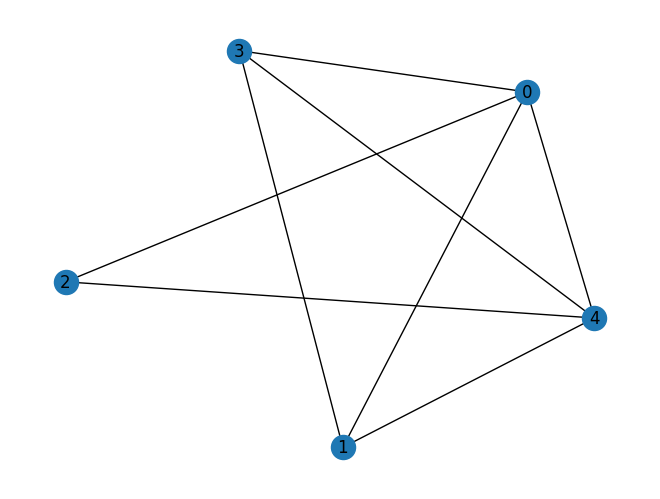

In [3]:
from MaxCutProblem import MaxCutProblem
problem = MaxCutProblem()
graphs = problem.get_erdos_renyi_graphs([5,7,9])

graph = graphs[1]
#graph = problem.get_graph_by_name(name)
#graph = load_graph_from_csv('data/11_nodes_links_scand.csv')
#draw_graph(graph, with_labels=True)

draw_graph(graph, with_labels=True)

In [4]:
quantum = QAOArunner(graph=graph, 
                     backend_mode = 'statevector',
                     param_initialization= 'static',
                     qaoa_variant='multiangle', 
                     optimizer='COBYLA',
                     warm_start=False,
                     depth = 4,
                     vertexcover=False,
                     amount_shots = 1000,
                     max_tol = 1e-2,
                     lagrangian_multiplier=2
                     )

quantum.get_init_params()

array([0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.9       , 0.9       ,
       0.9       , 0.9       , 0.9       , 0.36666667, 0.36666667,
       0.36666667, 0.36666667, 0.36666667, 0.36666667, 0.36666667,
       0.36666667, 0.63333333, 0.63333333, 0.63333333, 0.63333333,
       0.63333333, 0.63333333, 0.63333333, 0.63333333, 0.63333333,
       0.63333333, 0.63333333, 0.63333333, 0.63333333, 0.36666667,
       0.36666667, 0.36666667, 0.36666667, 0.36666667, 0.9       ,
       0.9       , 0.9       , 0.9       , 0.9       , 0.9       ,
       0.9       , 0.9       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       ])

SparsePauliOp(['IIIZZ', 'IIZIZ', 'IZIIZ', 'ZIIIZ', 'IZIZI', 'ZIIZI', 'ZIZII', 'ZZIII'],
              coeffs=[0.25 +0.j, 0.5  +0.j, 0.125+0.j, 0.25 +0.j, 0.125+0.j, 0.375+0.j,
 0.125+0.j, 0.5  +0.j])
[0, 1, 1, 1, 0]
3.75
1487
[ 1.09983067  0.1282214   0.26137411  1.42846434  0.0761336   0.31599331
 -0.21384499  0.23548456  0.78599617  1.21111957  2.36052346  1.15550767
  0.99320785  0.16695894  0.33319378  0.35673334  0.38911212  0.13171914
  1.40427516  0.35961024 -0.00515365  0.4910054   0.80479459  0.07843639
  0.7370015   0.87837036  0.56430288  0.3349862   0.82499071  2.12184576
  2.02528216  1.12418694  0.50863827  0.61785853  0.45565343  1.55852758
  0.36635802  1.32144892  0.59134485  0.89154977  0.46901244  0.73029862
  0.61439514  0.79650355  0.76371464  0.65203803  0.90292434  0.65350976
  1.31197316  0.18357576  0.33871479  0.19123842  1.3085645   0.46090267
  0.70972593  0.89255434  1.49196978  1.07465206  0.98325229  0.52420619
 -0.20182775  0.25255987  0.39430222 -0.1148

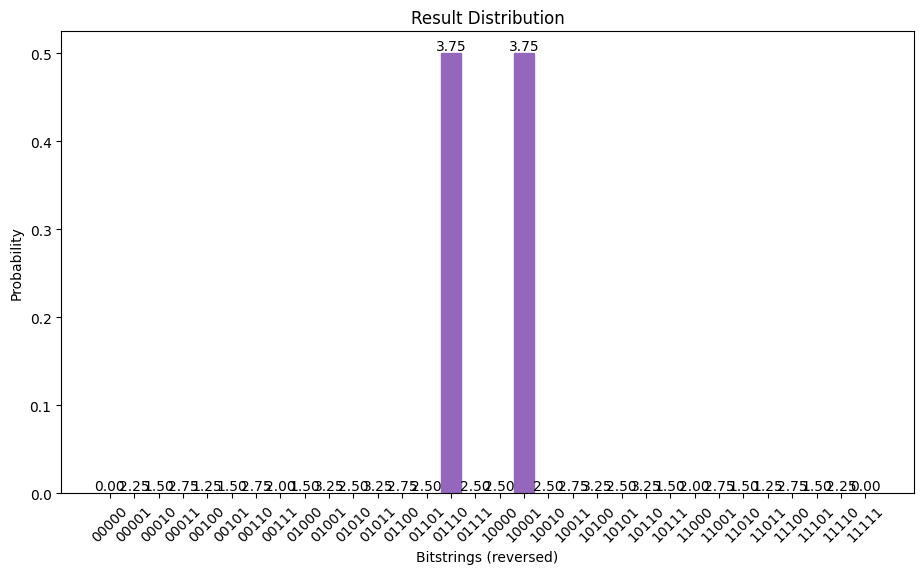

In [5]:
quantum = QAOArunner(graph=graph, 
                     backend_mode = 'statevector',
                     param_initialization= 'static',
                     qaoa_variant='multiangle', 
                     optimizer='COBYLA',
                     warm_start=False,
                     depth = 5,
                     vertexcover=False,
                     amount_shots = 1000,
                     max_tol = 1e-2,
                     lagrangian_multiplier=2
                     )

quantum.build_circuit()
print(quantum.cost_hamiltonian)
quantum.run()
print(quantum.solution)
print(quantum.evaluate_solution())
print(quantum.fev)
print(quantum.result.x)
print('m',quantum.get_prob_measure_optimal())
quantum.print_bitstrings()

In [ ]:
job = quantum.get_job_custom_circuit(quantum.circuit)
print((job.result()[0].data))
print(quantum.final_params)

DataBin(meas=BitArray(<shape=(), num_shots=1000, num_bits=5>))
[4.36003068 1.3645674 ]


Evaluating energy landscape: 100%|██████████| 100/100 [09:17<00:00,  5.57s/it]


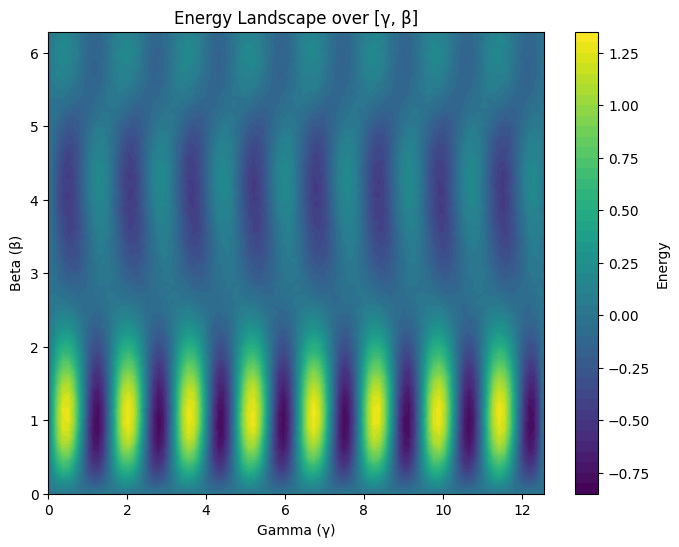

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from qiskit_ibm_runtime import EstimatorV2 as Estimator
# Define the grid resolution
num_points = 100
gamma_vals = np.linspace(0, 4 * np.pi, num_points)
beta_vals = np.linspace(0,2* np.pi, num_points)
Gamma, Beta = np.meshgrid(gamma_vals, beta_vals)
Z = np.zeros_like(Gamma)



minvertexcover = False

quantum = QAOArunner(graph=graph, 
                     backend_mode='statevector',
                     param_initialization= 'gaussian',
                     qaoa_variant='vanilla', 
                     optimizer='COBYLA',
                     warm_start=False,
                     depth = 1,
                     vertexcover=minvertexcover,
                     amount_shots = 1000,
                     max_tol = 1e-8,
                     lagrangian_multiplier=2
                     )
quantum.build_circuit()
estimator = Estimator(mode=quantum.backend)
estimator.options.default_shots = 5000
# Evaluate cost function at each grid point



for i in tqdm(range(Gamma.shape[0]), desc="Evaluating energy landscape"):
    for j in range(Gamma.shape[1]):
        params = np.array([Gamma[i, j], Beta[i, j]])  # Format your params as needed
        Z[i, j] = quantum.cost_func_estimator(params, quantum.circuit, quantum.cost_hamiltonian,estimator)

# Plot the energy landscape
plt.figure(figsize=(8, 6))
cp = plt.contourf(Gamma, Beta, Z, levels=50)
plt.colorbar(cp, label='Energy')
plt.title("Energy Landscape over [γ, β]")
plt.xlabel("Gamma (γ)")
plt.ylabel("Beta (β)")
plt.show()


In [ ]:
import pandas as pd

# Save Z as a CSV file
df_z = pd.DataFrame({'x': Gamma.ravel(), 'y': Beta.ravel(), 'z': Z.ravel()})
df_z.columns = ['x', 'y', 'z']
df_z.to_csv('percentage_measure_optimal_erdos_renyi_5_2_MaxCut.csv', index=False)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

strin = 'MinVertexCover' if minvertexcover else 'MaxCut'

import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=Z, x=Gamma, y=Beta, colorscale='Viridis')])
fig.update_layout(
    title=f"Percent chance of sampling optimal solution given [γ, β] for Erdos Renyi graph size 5, high prob of edges, for {strin}",
    scene=dict(
        xaxis_title="Gamma (γ)",
        yaxis_title="Beta (β)",
        zaxis_title="Energy"
    )
)
fig.show()

